## Import

In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

## Env

In [ ]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, gridworld_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point

        # 그리드 월드의 규격을 받는다.
        self.height, self.width = gridworld_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 위치 : 좌표로 나타남
        self.present_coords = start_point
        self.traces = []

        self.state_len = 15
        self.num_obs = 3 # 움직이는 장애물
        self.obs_coords = self.init_obs()

    def init_obs(self): # 장애물의 초기 위치 설정
        obs_coords = []
        while len(obs_coords) < self.num_obs:
            coord = (np.random.randint(0, self.height), np.random.randint(0, self.width))
            if coord != self.start_point and coord != self.end_point and coord not in obs_coords:
                obs_coords.append(coord)
        return obs_coords

    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        # 지나간 흔적
        traces = list(set(self.traces)) # 중복행동을 피하기 위해서
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[self.present_coords[0]][self.present_coords[1]] = "A" # 현재 에이전트의 위치

        for obs in self.obs_coords:
            self.grid_world[obs[0]][obs[1]] = "O"

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def reset(self):
        self.present_coords = self.start_point
        self.traces = []
        return self.get_state(self.present_coords)

    def step(self, action_idx:int):
        '''
        에이전트의 행동에 따라 주어지는 next_coords, reward, done
        '''
        # action and movement per action
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_coords = (self.present_coords[0]+row_movement, self.present_coords[1]+col_movement)
        next_coords = self.check_boundary(next_coords)

        self.move_obs() # 장애물 이동, 여기에서 장애물 위치 업데이트

        #  보상 함수
        if next_coords == self.end_point:
            reward = 1
            done = True
        elif next_coords in self.obs_coords: # 장애물이랑 부딪히면
            reward = -1
            done = False
        else:
            reward = 0
            done = False

        # 현재 위치 업데이트
        self.present_coords = next_coords
        self.traces.append(self.present_coords)

        state = self.get_state(self.present_coords)

        return state, reward, done

    def move_obs(self):
        next_coords = []
        for coord in self.obs_coords:
            action_idx = np.random.choice(self.action_space)
            action = self.actions[action_idx]
            next_coord = (coord[0]+action[0], coord[1]+action[1])
            next_coord = self.check_boundary(next_coord)
            if next_coord == self.end_point:
                next_coords.append(coord)
            else:
                next_coords.append(next_coord)
        self.obs_coords = next_coords

    def get_state(self, present_coords):
        '''
        1. 에이전트와 목적지의 상대적인 위치 (x, y)
        2. 목적지의 라벨 (0, 1)
        3. 에이전트와 장애물의 상대적인 위치 (x, y)
        4. 장애물의 라벨 (0, 1)
        5. 장애물의 속도
        '''
        states = list()

        # 1. 에이전트에 대한 목적지의 상대적인 위치 (x, y)
        states.append(self.end_point[0] - present_coords[0])
        states.append(self.end_point[1] - present_coords[1])

        # 2. 목적지의 라벨
        if present_coords == self.end_point:
            states.append(1)
        else:
            states.append(0)

        # 3. 에이전트에 대한 장애물의 상대적인 위치 (x, y)
        for obs in range(self.num_obs):
            obs = self.obs_coords[obs]
            states.append(obs[0] - present_coords[0])
            states.append(obs[1] - present_coords[1])
            # 4. 장애물 라벨
            if present_coords == obs:
                states.append(1)
            else:
                states.append(0)
            # 5. 장애물 속도
            states.append(1) # 항상 1이다.
        return states

    def check_boundary(self, coords):
        coords = list(coords)
        coords[0] = (0 if coords[0] < 0 else self.height - 1 if coords[0] > self.height - 1 else coords[0])
        coords[1] = (0 if coords[1] < 0 else self.width - 1 if coords[1] > self.width - 1 else coords[1])
        return tuple(coords)

## DNN

In [ ]:
class DNN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(state_size, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc_out = nn.Linear(30, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_out(x) # 출력이 큐함수이므로 softmax가 아닌 일반 선형 함수
        return x # action_size의 크기의 큐함수 텐서 반환

## Agent

In [ ]:
class DeepSARSAAgent:
    def __init__(self, state_size, action_size):

        self.state_size = state_size
        self.action_size = action_size

        # 하이퍼파라미터
        self.gamma = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.9999
        self.epsilon_min = 0.01

        # 큐함수를 근사할 심층신경망
        self.model = DNN(self.state_size, self.action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr = self.learning_rate)
        self.loss = nn.MSELoss() # MSE loss

    def get_action(self, state):

        self.model.eval() # 모델을 평가 모드로 전환
        state = torch.tensor(state, dtype=torch.float32)

        # 엡실론-탐욕정책
        if (random.uniform(0, 1) <= self.epsilon):
            return np.random.choice(self.action_size) # 랜덤 반환
        else:
            q_vals = self.model(state) # 상태에서 각 행동의 큐함수 텐서 반환
            max_action = torch.argmax(q_vals).item() # 가장 큰 큐함수를 가지는 행동 인덱스 반환
            return max_action

    def train_model(self, state, action_idx, reward, next_state, next_action_idx, done):

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay # 엡실론의 하한까지 엡실론을 decay

        self.model.train() # 모델을 훈련 모드로 전환

        # 심층신경망을 통과해야 하므로 텐서로 바꿔줌
        state = torch.tensor(state, dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32)

        y_pred = self.model(state) # 상태에서 각 행동의 큐함수 텐서 반환
        y_pred = y_pred[action_idx] # 실제로 한 행동의 큐함수만 추출

        next_q = self.model(next_state)[next_action_idx]
        target = reward + (1-done)*self.gamma*next_q # 만약 done이라면 다음 상태의 보상만 받고 끝내기

        # MSE loss
        loss = self.loss(y_pred, target)

        # 파라미터 업데이트
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

## Main loop

In [ ]:
if __name__ == '__main__':
    env = GridWorldEnvironment(start_point=(0, 0),
                                end_point=(4, 4),
                                gridworld_size=(5, 5))
    agent = DeepSARSAAgent(env.state_len, env.num_actions) # 장애물이 없는 상황이라서 에이전트에 대한 도착지점의 상대 위치 x, y, 도착지점의 라벨 (done) -> 3개가 상태의 특징이 됨.

    EPISODES = 1000
    total_moves = []
    scores = []

    for epi in range(EPISODES):
        done = False
        score = 0
        moves_cnt = 0
        state = env.reset()
        action_idx = agent.get_action(state)

        while not done:
            next_state, reward, done = env.step(action_idx)
            next_action_idx = agent.get_action(next_state)
            # 큐함수 업데이트
            agent.train_model(state, action_idx, reward, next_state, next_action_idx, done)

            state = next_state
            action_idx = next_action_idx
            moves_cnt += 1
            score += reward
        total_moves.append(moves_cnt)
        scores.append(score)

        if epi%100 == 0:
            print(f"EPISODE {epi}:\nNum of Moves Mean: {np.mean(total_moves[-100:]):.4f}\nEpsilon: {agent.epsilon:.4f}\nScore Mean: {np.mean(scores[-100:]):.4f}\n\n")

EPISODE 0:
Num of Moves Mean: 257.0000
Epsilon: 0.9746
Score Mean: -36.0000


EPISODE 100:
Num of Moves Mean: 48.3300
Epsilon: 0.6011
Score Mean: -4.2700


EPISODE 200:
Num of Moves Mean: 23.5200
Epsilon: 0.4751
Score Mean: -1.7700


EPISODE 300:
Num of Moves Mean: 16.6600
Epsilon: 0.4022
Score Mean: -0.8600


EPISODE 400:
Num of Moves Mean: 14.4900
Epsilon: 0.3479
Score Mean: -0.8700


EPISODE 500:
Num of Moves Mean: 15.4300
Epsilon: 0.2982
Score Mean: -0.6900


EPISODE 600:
Num of Moves Mean: 12.9500
Epsilon: 0.2620
Score Mean: -0.3000


EPISODE 700:
Num of Moves Mean: 15.3600
Epsilon: 0.2247
Score Mean: -0.9300


EPISODE 800:
Num of Moves Mean: 12.0600
Epsilon: 0.1991
Score Mean: -0.2600


EPISODE 900:
Num of Moves Mean: 11.1300
Epsilon: 0.1782
Score Mean: -0.2600




In [ ]:
env.render() # 마지막 상황만 렌더링

S X . . . 
X O . . . 
X X . . . 
X . . . . 
X X O O A 



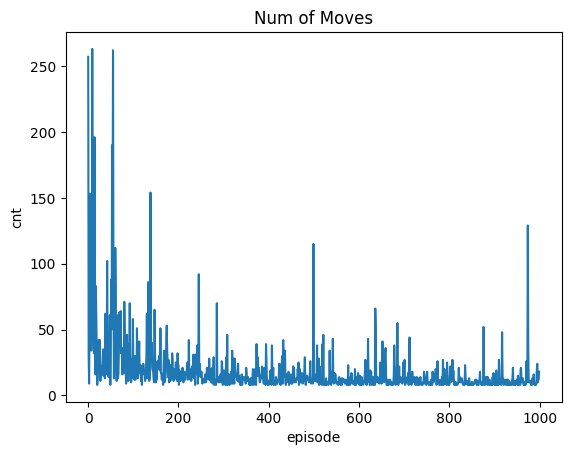

In [ ]:
plt.plot(total_moves)
plt.ylabel('cnt')
plt.xlabel('episode')
plt.title('Num of Moves')
plt.show()

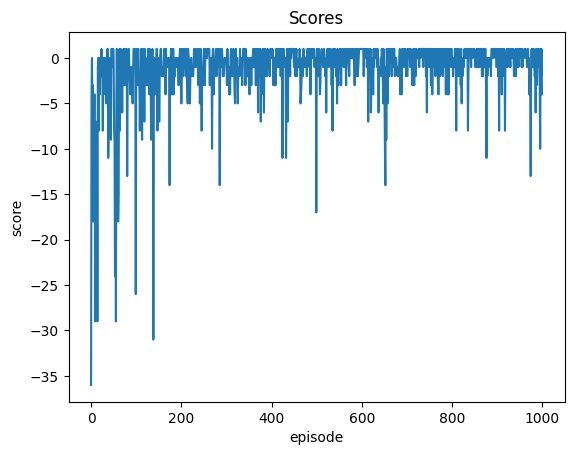

In [ ]:
plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episode')
plt.title('Scores')
plt.show()